# training check

In [1]:
import sys
#sys.path.append('./../')
import numpy as np
import torch
from datasets.dataset_multitask_1d import motask_generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nchannels = 3
in_channels = nchannels


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18


plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [3]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# # from test_baseline import Convcnp,compute_loss_baseline
# # from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# # #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# # from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        
# import sys
# sys.path.append('./../')

from models.test_baseline import Convcnp,compute_loss_baseline
from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from models.test_cnp import RegressionANP, RegressionCNP
from torch.distributions.normal import Normal

num_nchannels= 1
nsamples_latent=10
nsamples_gp=10

lr = 0.001
weight_decay=1e-4
def get_model(modelname='gp',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_nchannels,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #----------------------
    #needed to check run
    #----------------------
    if modelname == 'anp':
        num_samples = 1        
        model = RegressionANP(input_dim=num_nchannels,
                              latent_dim=128,
                              num_channels=num_nchannels).cuda()        
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)        
        lossfun = compute_loss_baseline
        
        
    if modelname == 'cnp':
        num_samples = 1                
        model = RegressionCNP(input_dim=num_nchannels,
                              latent_dim=128,
                              num_channels=num_nchannels).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)        
        lossfun = compute_loss_baseline
        
      
    return model,opt,lossfun





proposed_model_list = ['gpind','gpdep']
def validate_epochs_pair(batch_dataset_pair,model,lossfun):
    # large is better 
    
    model.eval()
    
    likelihoods = []
    likelihoods2 = []    
    ntask = len(batch_dataset_pair)
    for dataset_pair in batch_dataset_pair:
        
#        try:        
        context_x,context_y,target_x,target_y,full_x,full_y = dataset_pair        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)


        outs = model(context_x.cuda(),context_y.cuda(),target_x.cuda())                        
        obj = -lossfun( outs.pymu, outs.pystd, target_y.cuda(), intrain=False, reduce=False)        
            
        likelihoods += list(obj.cpu().data.numpy())        

        
    
    
    likelihoods=np.array(likelihoods)                
    num_nanlikelihoods = np.count_nonzero(~np.isnan(likelihoods))
    avg_ll,std_ll = np.nanmean(likelihoods).round(2), (np.nanstd(likelihoods)/np.sqrt(num_nanlikelihoods+1e-8)).round(2)    
    
    num_nanlikelihoods2 = np.count_nonzero(~np.isnan(likelihoods2))    
    avg_ll2,std_ll2 = np.nanmean(likelihoods2).round(2), (np.nanstd(likelihoods2)/np.sqrt(num_nanlikelihoods2+1e-8)).round(2)    
    
    return avg_ll,std_ll,avg_ll2,std_ll2      

    


    

## loads dataset and checks

In [5]:
#pstd_xt
import matplotlib.pyplot as plt

figsiz_=(20,2)
color_list = ['r','b','g']
predicted_model_list = ['gpind','gpdep','baselatent']

## Take models and load params

## load params

In [6]:
testtype = 'extra'
dep = True
tasktype = 'singletask'
bestparam_path = './bestparams/bestparam_{}/'.format(tasktype)
bestparam_path

'./bestparams/bestparam_singletask/'

## load saved model params

In [7]:
import glob
def filter_savefilename(bestparam_path, depoption=True,modelname=[],datav=['datav4'],runv=['runv25']):
    
    saved_modelparam_path_list = glob.glob(bestparam_path +'*.pth'.format(tasktype))
    saved_modelparam_path_list.sort()
    saved_modelparam_path_list
    
    outs = []
    for ith in saved_modelparam_path_list:
        spec = ith.split('/')[-1].split('_')
        condi1 = spec[7] in datav and datav is not None
        condi2 = spec[9] in runv and runv is not None
        if len(modelname) == 0:
            condi3 = True
        else:
            condi3 = spec[2] in modelname             
        condi4 = spec[0] == 'dep'+str(depoption)
            
        if condi1 and condi2 and condi3 and condi4:                                                         
            outs.append(ith)
    #print(outs)
    return outs

## Check prediction results for small context set (datav = 1) 

In [8]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch


In [9]:
datav = 1

# load dataset

In [10]:
#saved_dataset_list
saved_dataset_list = glob.glob('./syndata_{}_v{}_test/dep{}*.db'.format(tasktype,datav,dep))

testset_dict = torch.load(saved_dataset_list[0])
print('-'*100)
print('dataset loaded')
print('loaded file : {}'.format(saved_dataset_list[0]))
print('-'*100)





----------------------------------------------------------------------------------------------------
dataset loaded
loaded file : ./syndata_singletask_v1_test/depTrue_extra_nvaltask32.db
----------------------------------------------------------------------------------------------------


# load modelparams for task-depednet prior model (gpdep)

In [12]:

modelparam_path = filter_savefilename(bestparam_path,depoption=dep,modelname=['gpdep'],datav=['datav{}'.format(datav)],runv=['runv1'])[0] #shallow network

print('-'*100)
print('saved param loaded')
#print('loaded file : {}'.format(saved_dataset_list[0]))
print(modelparam_path)
print('-'*100)


----------------------------------------------------------------------------------------------------
saved param loaded
./bestparams/bestparam_singletask/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav1_gppriorscale1.0_runv1_reglam0.0.pth
----------------------------------------------------------------------------------------------------


In [13]:

nch=0
fontsiz_=13
figsiz_=(8.0,1.8)
alpha_=0.2
eps=0.5
ylim_ = [-1-eps,1+eps]
delta=0.1

ylimlist_ = [[-2-delta,2+delta],[-2-delta,2+delta],[-2-delta,3+delta],[0-delta,1.1+delta]]


# prediction on target set measured inside training range

current task: rbf
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


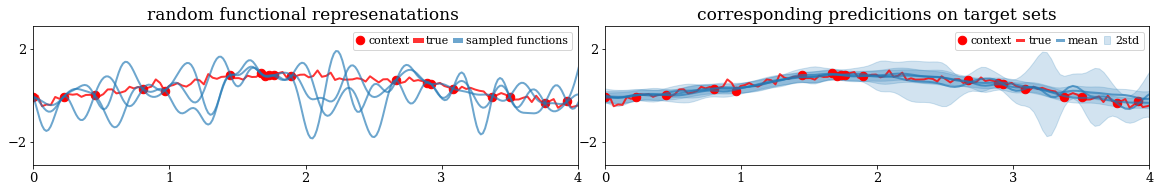

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


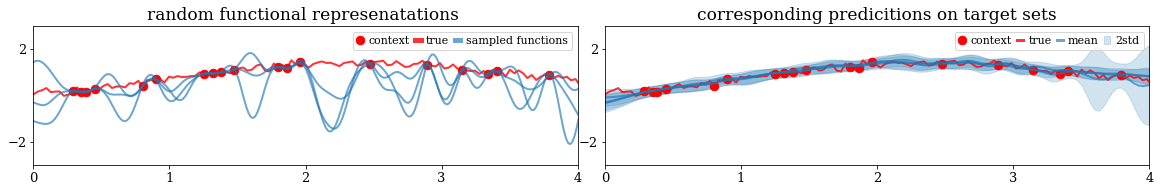

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


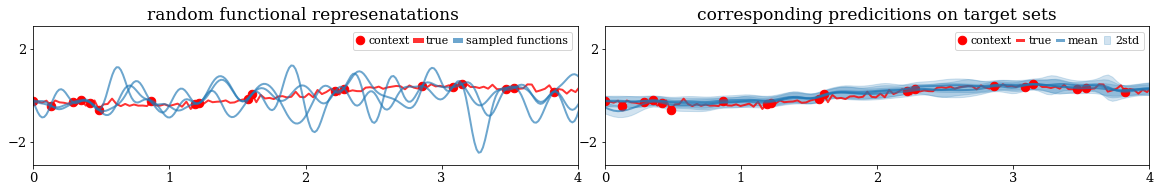






current task: matern
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


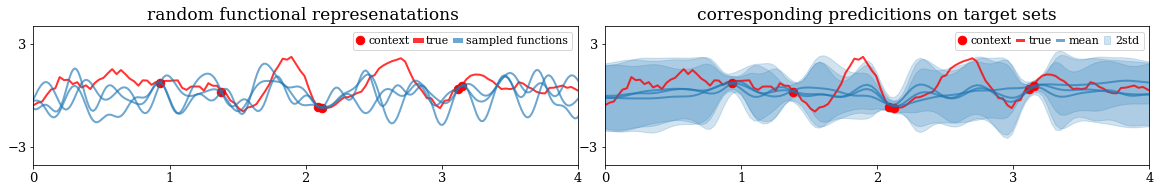

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


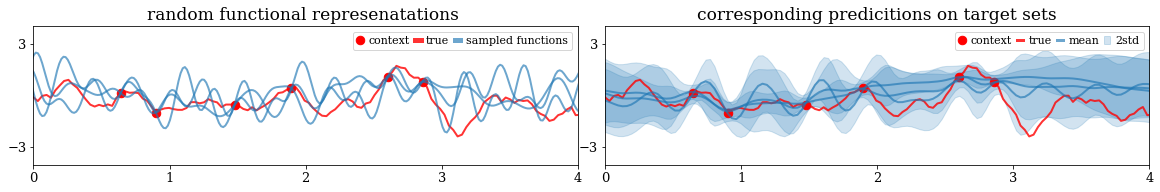

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


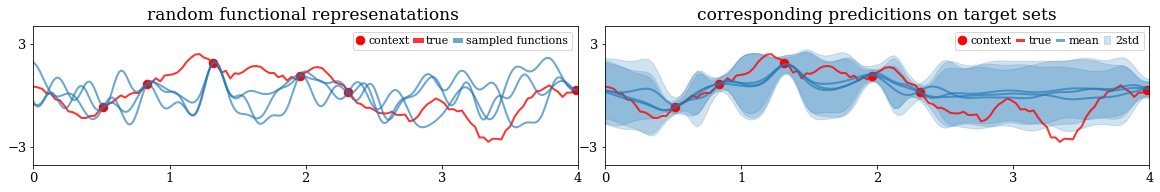






current task: weaklyperiodic
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


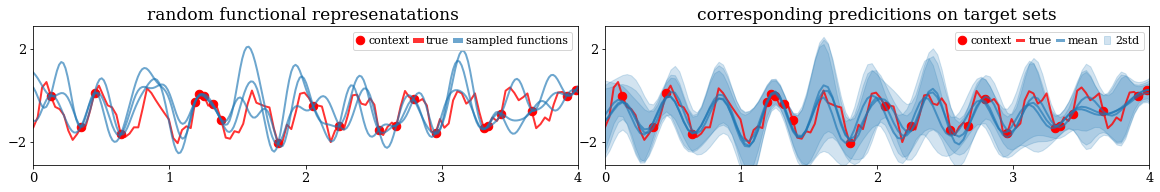

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


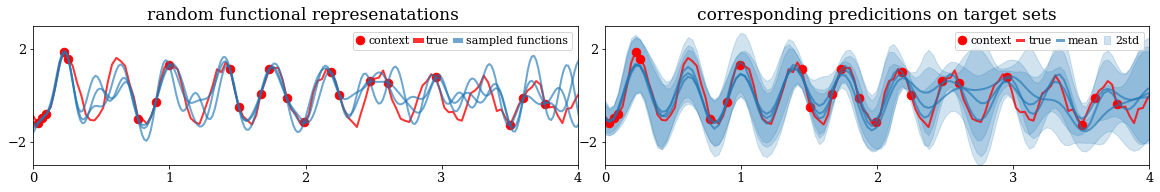

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


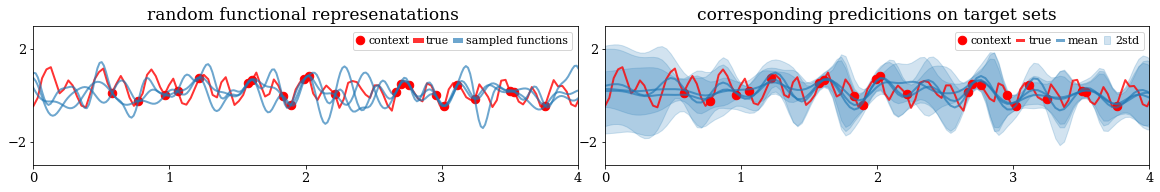






current task: sawtooth
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


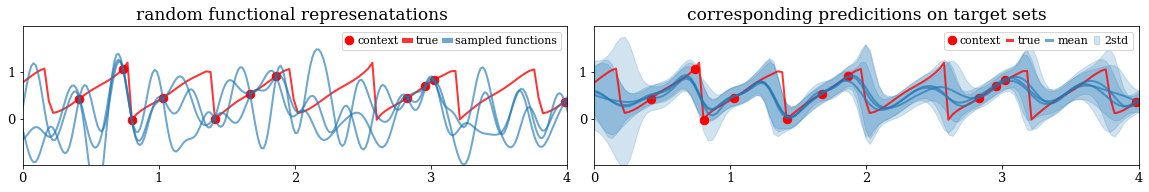

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


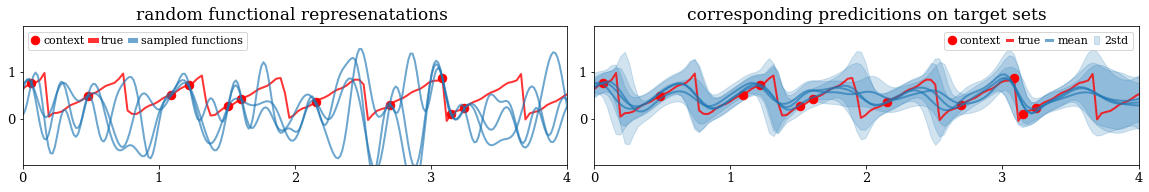

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


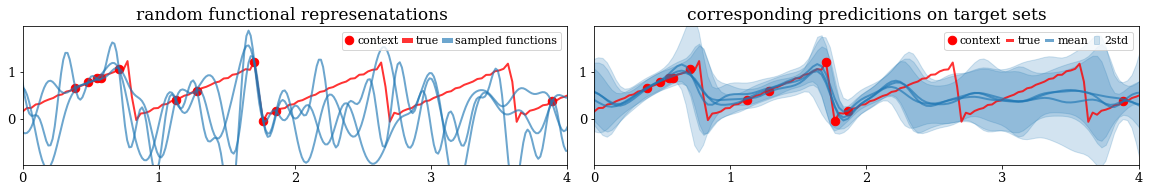

In [43]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch

fontsiz_=13
#figsiz_=(8.0,1.8)
figsiz_=(20.0,2.55)

alpha_=0.2
eps=0.5
ylim_ = [-1-eps,1+eps]


chosenidx=0
inrangetask = True
# if inrangetask:
#     xlim_ = [0-delta,4+delta]
# else:    
#     xlim_ = [4-delta,8+delta]
xlim_ = [0,4]
xticks_=np.linspace(xlim_[0],xlim_[1],5)





task_list = [4,8,12]
for ith,ith_key in enumerate(testset_dict):
    ith_taskset = testset_dict[ith_key]    
    
    if inrangetask:
        xc,yc,xt,yt,xf,yf = ith_taskset['train_set'][chosenidx] #inrage
    else:
        xc,yc,xt,yt,xf,yf = ith_taskset['valid_set'][chosenidx] #inrage
        
    #-----------------------------------------
    #prediction
    #-----------------------------------------
    print('current task: {}'.format(ith_key))
            
    #modelname='gpdep'
    #cnntype='deep'

    _,_,param_saved,param_detail = modelparam_path.split('/')        
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    runv = param_detail.split('_')[9
                                  ]    
    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(modelparam_path)
    
    model.load_state_dict(saved_dict['state_dict'])                
    spec = modelname + cnntype + runv
    xstar,ystar = xf,yf  
    
    
    #model.train()    
    model.eval()
    if model.modelname in proposed_model_list:
        tmp_numsamples=3
        model.num_samples = tmp_numsamples                     
        outs = model(xc[:,:,None,:].cuda(),yc.cuda(),xstar[:,:,None,:].cuda())  
        
    else:
        outs = model(xc.cuda(),yc.cuda(),xstar.cuda())       
    pmu_xt,pstd_xt = outs.pymu,outs.pystd


    #-----------------------------------------
    #figures
    #-----------------------------------------
    #------------------        
    #nbidx=7
    #------------------        
    for nbidx in task_list:
        print('-'*100)
        print('current task idx {}'.format(nbidx))
        print('-'*100)

        fontsiz_=13    
        #print(param_detail)
        #print(param_detail)
        fig = plt.figure(figsize=figsiz_)   
        plt.subplots_adjust(wspace=0.05)


        #------------------------------------------------------------------------------------
        # construcut functional representaions
        #------------------------------------------------------------------------------------    
        plt.subplot(1,2,1)        
        print('xc.shape {}, yc.shape {}, xt.shape{}, yt.shape{}'.format(xc.shape,yc.shape,xstar.shape,ystar.shape))
        post_samples=outs.gpouts.posterior_samples
        xa=outs.gpouts.xa_samples        
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')    
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')


        for j in range(tmp_numsamples):    
            if j ==0:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label = 'sampled functions')          
            else:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65)          


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        #plt.yticks([-1,1],fontsize=fontsiz_)
        plt.title('random functional represenatations ',fontsize=17)

        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)    
        for line in leg.get_lines():
            line.set_linewidth(5) 
            line.set_markersize(5)     







        #------------------------------------------------------------------------------------
        # prediction    
        #------------------------------------------------------------------------------------
        plt.subplot(1,2,2)
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')

        #tmp_num_samples=3
        for j in range(tmp_numsamples):    
            mean=pmu_xt[j,nbidx,:,nch].cpu().data.numpy()
            ub=(pmu_xt+2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()
            lb=(pmu_xt-2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()                

            if j ==0:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label='mean') #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_,
                                 label='2std')        

            else:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65) #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_)        


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        plt.title('corresponding predicitions on target sets',fontsize=17)

        #if ith_key == 'matern':
        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)        
        for line in leg.get_lines():
            line.set_linewidth(3) 
            line.set_markersize(3)  

        plt.show()
    print('\n'*4)
    
    
    

# prediction on target set measured outside training range

spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


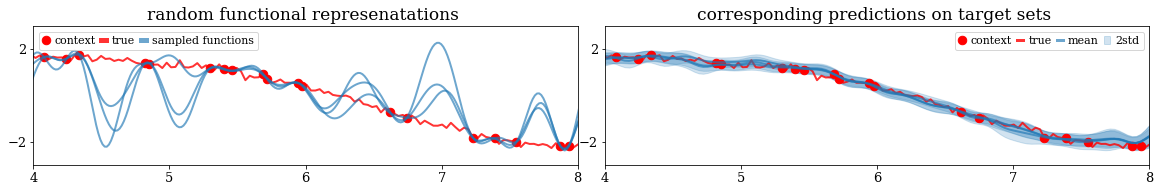

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


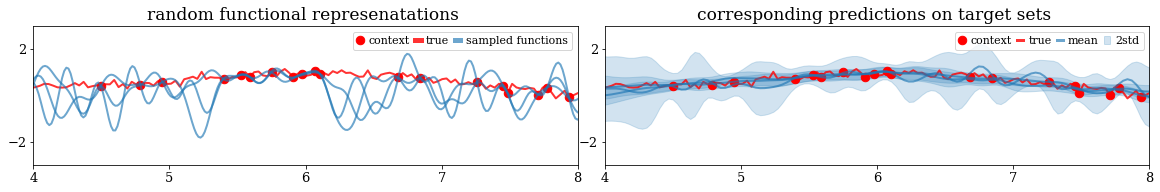

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


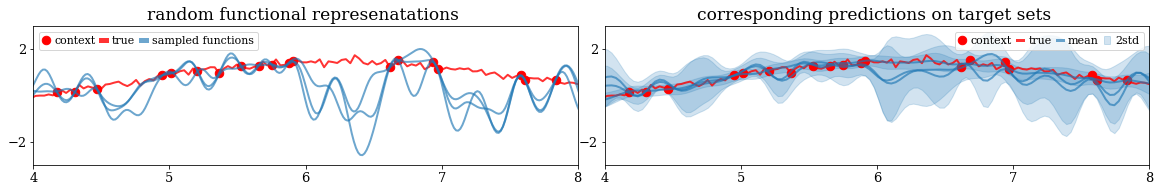






spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


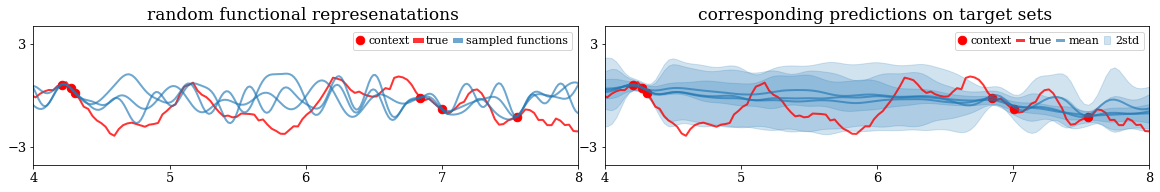

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


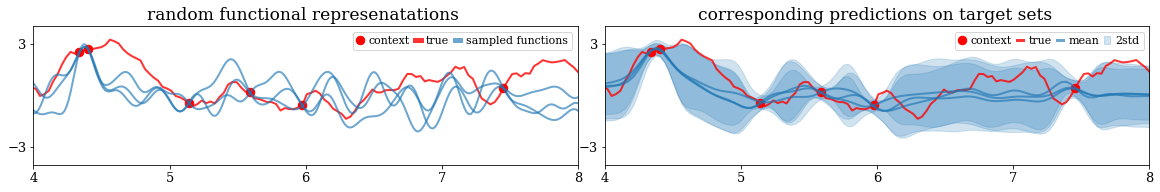

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


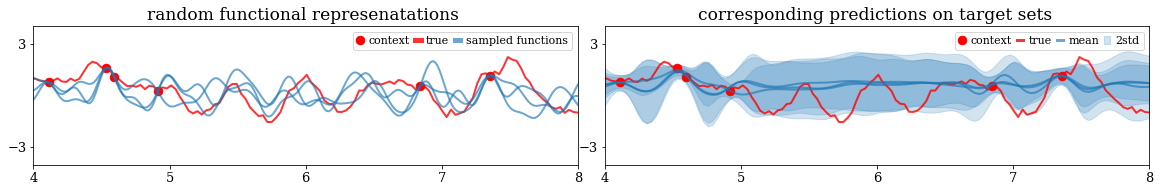






spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


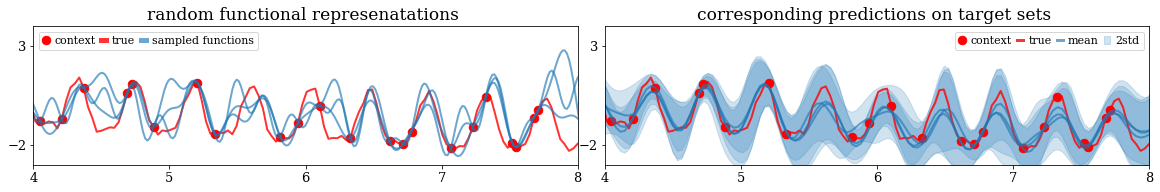

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


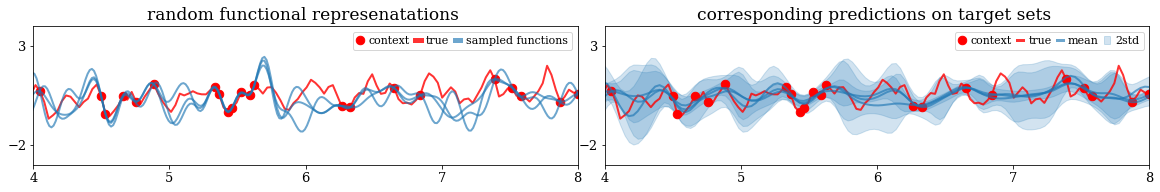

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


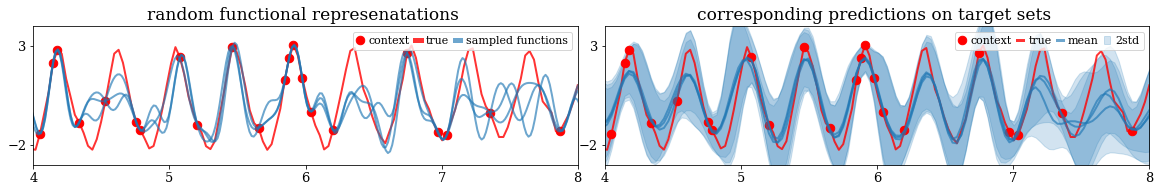






spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


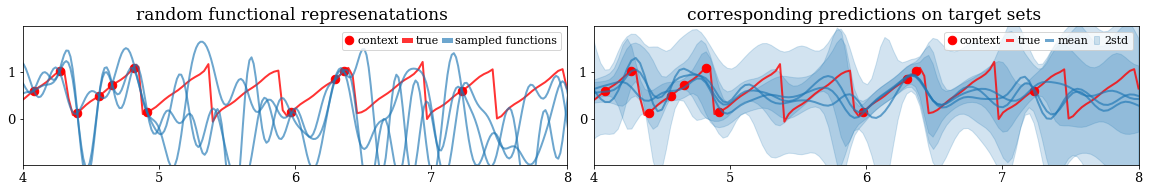

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


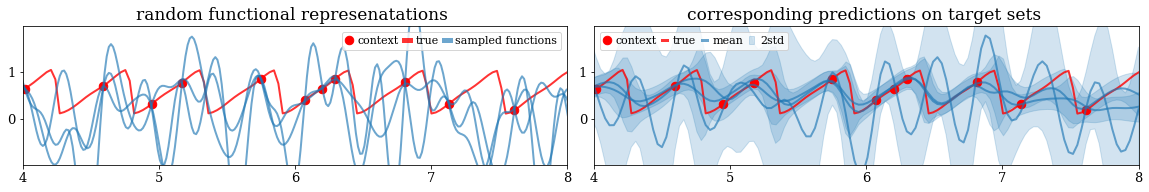

----------------------------------------------------------------------------------------------------
current task idx 12
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


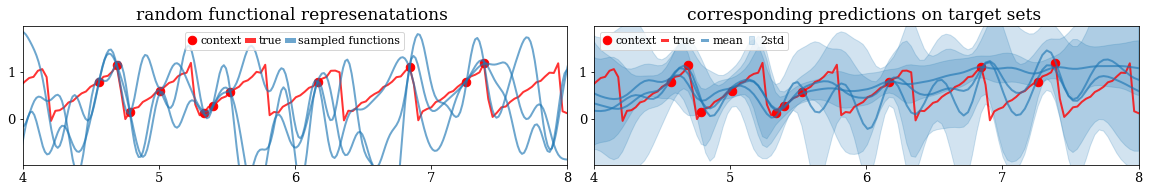

In [44]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch


#chosenidx=0
inrangetask = False
xlim_ = [4,8]
xticks_=np.linspace(xlim_[0],xlim_[1],5)




for ith,ith_key in enumerate(testset_dict):
    ith_taskset = testset_dict[ith_key]    
    #testset_inrange = ith_taskset['train_set'][nbidx]
    #testset_outrange = ith_taskset['valid_set']    
    
    if inrangetask:
        xc,yc,xt,yt,xf,yf = ith_taskset['train_set'][chosenidx] #inrage
    else:
        xc,yc,xt,yt,xf,yf = ith_taskset['valid_set'][chosenidx] #inrage
        
    #-----------------------------------------
    #prediction
    #-----------------------------------------
    _,_,param_saved,param_detail = modelparam_path.split('/')        
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    runv = param_detail.split('_')[9
                                  ]    
    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])                
    spec = modelname + cnntype + runv
    xstar,ystar = xf,yf  
    
    
    #model.train()    
    model.eval()
    if model.modelname in proposed_model_list:
        tmp_numsamples=3
        model.num_samples = tmp_numsamples                     
        outs = model(xc[:,:,None,:].cuda(),yc.cuda(),xstar[:,:,None,:].cuda())  
        
    else:
        outs = model(xc.cuda(),yc.cuda(),xstar.cuda())       
    pmu_xt,pstd_xt = outs.pymu,outs.pystd


    #-----------------------------------------
    #figures
    #-----------------------------------------
    #------------------        
    #nbidx=7
    #------------------        
    for nbidx in task_list:
        print('-'*100)
        print('current task idx {}'.format(nbidx))
        print('-'*100)

        fontsiz_=13    
        #print(param_detail)
        #print(param_detail)
        fig = plt.figure(figsize=figsiz_)   
        plt.subplots_adjust(wspace=0.05)


        #------------------------------------------------------------------------------------
        # construcut functional representaions
        #------------------------------------------------------------------------------------    
        plt.subplot(1,2,1)        
        print('xc.shape {}, yc.shape {}, xt.shape{}, yt.shape{}'.format(xc.shape,yc.shape,xstar.shape,ystar.shape))
        post_samples=outs.gpouts.posterior_samples
        xa=outs.gpouts.xa_samples        
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')    
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')


        for j in range(tmp_numsamples):    
            if j ==0:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label = 'sampled functions')          
            else:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65)          


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        #plt.yticks([-1,1],fontsize=fontsiz_)
        plt.title('random functional represenatations ',fontsize=17)
        

        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)    
        for line in leg.get_lines():
            line.set_linewidth(5) 
            line.set_markersize(5)     







        #------------------------------------------------------------------------------------
        # prediction    
        #------------------------------------------------------------------------------------
        plt.subplot(1,2,2)
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')

        #tmp_num_samples=3
        for j in range(tmp_numsamples):    
            mean=pmu_xt[j,nbidx,:,nch].cpu().data.numpy()
            ub=(pmu_xt+2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()
            lb=(pmu_xt-2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()                

            if j ==0:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label='mean') #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_,
                                 label='2std')        

            else:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65) #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_)        


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        plt.title('corresponding predictions on target sets ',fontsize=17)
        

        #if ith_key == 'matern':
        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)        
        for line in leg.get_lines():
            line.set_linewidth(3) 
            line.set_markersize(3)  

        plt.show()
    print('\n'*4)



# Quantative analysis of task-depedent prior 

In [45]:
from collections import OrderedDict

In [46]:
#-----------------------------------------
#prediction
#-----------------------------------------
_,_,param_saved,param_detail = modelparam_path.split('/')        
tasktype = param_saved.split('_')[1]
deptype = param_detail.split('_')[0]
modelname = param_detail.split('_')[2]
cnntype = param_detail.split('_')[4]
runv = param_detail.split('_')[9                              ]    
model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
saved_dict = torch.load(modelparam_path)
model.load_state_dict(saved_dict['state_dict'])                
spec = modelname + cnntype + runv


if modelname == 'gpdep':

    weight_samples = OrderedDict()
    for ith,ith_key in enumerate(testset_dict):
        ith_taskset = testset_dict[ith_key]    

        if inrangetask:
            task_purpose = 'train_set'
        else:
            task_purpose = 'valid_set'




        neural_logits_list = []                    
        #print(model)
        print('current task: {}'.format(ith_key))                    
        for chosenidx in range(len(ith_taskset[task_purpose])):


            xc,yc,xt,yt,xf,yf = ith_taskset[task_purpose][chosenidx] #inrage
            xstar,ystar = xf,yf  
            #xstar,ystar = xt,yt  


            #model.train()    
            model.eval()
            #tmp_numsamples=10
            tmp_numsamples=10        
            post_samples,xa  = model.sample_functionalfeature(xc[:,:,None,:].cuda(),yc.cuda(),xstar[:,:,None,:].cuda(),numsamples=tmp_numsamples)       
            model.num_samples = tmp_numsamples                     
            outs = model(xc[:,:,None,:].cuda(),yc.cuda(),xt[:,:,None,:].cuda())       

            mu = model.gpsampler.logmu.exp()
            inv_std = 1/model.gpsampler.logstd.exp()
            neural_logits_list.append(model.gpsampler.neural_logits)    


        tensor_prob=torch.cat(neural_logits_list,dim=0)
        prob_m = tensor_prob.mean(dim=0).cpu().data.numpy().round(3) 
        prob_s = tensor_prob.std(dim=0).cpu().data.numpy().round(3) 


        print('tensor_prob.shape {}'.format(tensor_prob.shape))
        print('prob mean : {}'.format(prob_m))
        print('prob std: {}'.format(prob_s))    


        #OrderedDict[task_purpose] = tensor_prob[:,0,:].cpu().data.numpy()
        weight_samples[ith_key] = tensor_prob[:,0,:].cpu().data.numpy()

        #plot_points(tensor_prob[:,0,:].cpu().data.numpy())
        #plt.show()

        #print()
        print('\n')
else:
    pass
    

spikeslab version 7 with tempering 0.1
current task: rbf
tensor_prob.shape torch.Size([512, 1, 3])
prob mean : [[0.017 0.671 0.312]]
prob std: [[0.02  0.179 0.171]]


current task: matern
tensor_prob.shape torch.Size([512, 1, 3])
prob mean : [[0.008 0.595 0.397]]
prob std: [[0.013 0.17  0.17 ]]


current task: weaklyperiodic
tensor_prob.shape torch.Size([512, 1, 3])
prob mean : [[0.005 0.44  0.555]]
prob std: [[0.012 0.202 0.204]]


current task: sawtooth
tensor_prob.shape torch.Size([512, 1, 3])
prob mean : [[0.026 0.541 0.433]]
prob std: [[0.029 0.072 0.058]]




In [47]:

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
#_corners = np.array([[0, 0], [0.5, 0.75**0.5], [1, 0]])
#_corners = np.array([[0, 0], [1, 0], [0.5, 1]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return np.clip(coords, tol, 1.0 - tol)


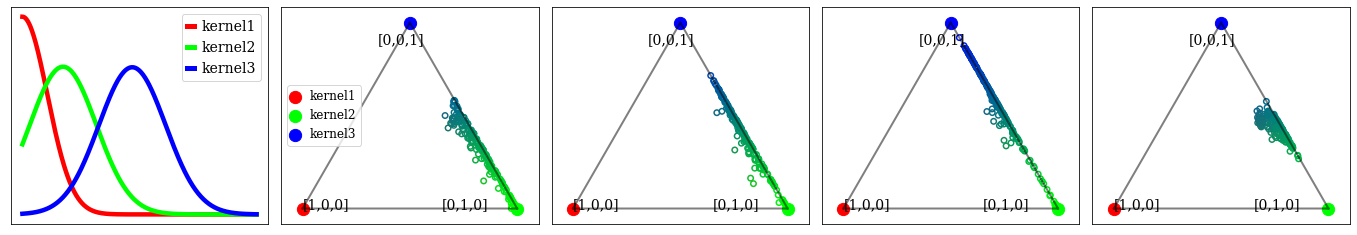

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

numtask_per_process = []
if modelname == 'gpdep':

    color_list2 = [[1,0,0],[0,1,0],[0,0,1]]
    figsiz__=(6*4,4)


    fig = plt.figure(figsize=figsiz__)            
    plt.subplots_adjust(wspace=0.05)


    plt.subplot(1,5,1)    
    #ax.tick_params(axis="x",direction="in", pad=2)
    x_axis=np.linspace(0,7,7*50)
    for i,(imu,istd) in enumerate(zip(mu,inv_std)):
        plt.plot(x_axis, 1+norm.pdf(x_axis,imu.cpu().data.numpy(),1*istd.cpu().data.numpy()),
                 linewidth=4.5,
                 color=color_list2[i],label = 'kernel{}'.format(i+1))

    plt.yticks([])
    plt.xticks([])
    plt.xticks(fontsize=13)
    leg=plt.legend(loc='upper right',fontsize=14,ncol=1,columnspacing=0.5,handlelength=0.5,handletextpad=.5)
    for line in leg.get_lines():
        line.set_linewidth(5) 
        line.set_markersize(5)   


    for i,ikey in enumerate(weight_samples):
        plt.subplot(1,5,i+2)    
        X=weight_samples[ikey]
        #if barycentric is True:
        X = X.dot(_corners)
        scales_=3
        plt.scatter(X[::scales_, 0], X[::scales_, 1] ,
                    s=30 , 
                    color=weight_samples[ikey][::scales_]  ,
                    alpha=1.,
                    linewidth=1.5,
                    facecolors='none')
        numtask_per_process.append(len(X[::scales_, 0]))

        #plt.triplot(_triangle, linewidth=1)
        plt.triplot(_triangle, linewidth=2,color='k',alpha=0.5 )

        for j,j_corners in enumerate(_corners):
            #plt.scatter(j_corners[0],j_corners[1],color=color_list[j],s=100)
            plt.scatter(j_corners[0],j_corners[1],color=color_list2[j],s=150,label='kernel{}'.format(j+1))

        plt.text(_corners[0][0],_corners[0][1],'[1,0,0]',fontsize=14)
        plt.text(_corners[1][0]-0.35,_corners[1][1],'[0,1,0]',fontsize=14)
        plt.text(_corners[2][0]-0.15,_corners[2][1]-0.1,'[0,0,1]',fontsize=14)

        if i == 0:
            plt.legend(loc='center left',fontsize=12,ncol=1,columnspacing=0.4,handlelength=0.5,handletextpad=1.0)
            #plt.legend(loc='upper left',fontsize=11,ncol=1,columnspacing=0.4,handlelength=0.5,handletextpad=1.0)

        eps=0.1
        plt.axis('equal')
        plt.xlim(0-eps, 1+eps)
        plt.ylim(0-eps, 0.75**0.5 + eps)
        plt.xticks([])
        plt.yticks([])
        #plt.axis('on')
    #plt.savefig('tmp1'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
    #plt.show()

    plt.show()
else:
    pass


In [51]:
print('numtask_per_process')
print(list(testset_dict.keys()))
print(numtask_per_process)

numtask_per_process
['rbf', 'matern', 'weaklyperiodic', 'sawtooth']
[171, 171, 171, 171]
